In [185]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

In [186]:

data=pd.read_csv("./laboratory.csv")

In [187]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,14.966,20.688,0.007,4.867,1.522,20.867,910.0,548.505,1876,38.461,...,968.0,24.841,0.014,11.550,44.833,-0.03,8.182,21.999,0.0,16.234
1,14.996,20.687,0.001,3.496,1.521,20.865,915.0,543.500,1887,38.462,...,942.0,24.845,0.002,11.520,44.784,-0.06,8.172,24.962,0.0,14.324
2,15.000,20.687,0.000,5.134,1.521,20.866,916.0,542.134,1858,38.463,...,938.0,24.834,0.000,11.506,44.768,-0.07,8.170,25.293,0.0,15.826
3,14.081,20.688,0.213,4.223,1.521,20.864,918.0,539.314,1856,38.462,...,936.0,24.834,0.618,11.438,44.766,-0.04,8.169,26.403,0.0,12.719
4,14.258,20.687,0.152,8.701,1.522,20.867,915.0,543.551,1862,38.462,...,935.0,24.838,0.543,11.393,44.768,0.00,8.170,25.934,0.0,26.107


In [188]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
51181,2.257,20.906,4.770,227.998,1.530,24.533,798.0,517.499,2046,176.872,...,820.0,28.700,0.958,28.679,39.472,-0.18,8.888,66.425,4.150,710.289
51182,1.920,20.906,4.169,229.625,1.529,24.546,782.0,524.201,2088,177.372,...,844.0,28.721,0.405,28.932,39.171,-0.30,8.826,65.066,3.800,725.006
51183,1.688,20.907,5.038,228.146,1.529,24.572,772.0,516.942,1827,173.799,...,803.0,28.757,0.529,29.264,38.641,-0.56,8.720,62.035,4.670,721.098
51184,1.515,20.905,5.092,246.341,1.530,24.590,761.0,517.797,1828,167.632,...,790.0,28.797,0.394,29.504,38.329,-0.63,8.658,65.898,4.789,780.604
51185,1.225,20.907,4.216,229.139,1.532,24.614,758.0,512.732,1999,162.133,...,822.0,28.815,0.840,29.658,38.106,-0.60,8.619,64.354,4.177,726.724


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [189]:
print(data)

        TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      14.966  20.688  0.007    4.867  1.522       20.867        910.0   
1      14.996  20.687  0.001    3.496  1.521       20.865        915.0   
2      15.000  20.687  0.000    5.134  1.521       20.866        916.0   
3      14.081  20.688  0.213    4.223  1.521       20.864        918.0   
4      14.258  20.687  0.152    8.701  1.522       20.867        915.0   
...       ...     ...    ...      ...    ...          ...          ...   
51181   2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182   1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183   1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184   1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185   1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      548.505         1876   38.46

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [190]:

data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

start_date = '2023-04-19'
end_date = '2023-06-03'
data = data[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date)]
# dates_to_remove = ['2023-04-17', '2023-05-21']
# dates_to_remove = pd.to_datetime(dates_to_remove)
# data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
# data = data[(data != 0).all(axis=1)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]
print(data)

       oxygen    pm10     co      co2       so2     no2           timestamp  \
18440  20.789   9.315  1.735  507.934  2216.850  21.831 2023-04-19 11:39:01   
18441  20.790   9.040  1.730  504.029  2216.820  21.776 2023-04-19 11:41:03   
18442  20.789  10.338  1.726  503.302  2216.730  22.191 2023-04-19 11:43:05   
18443  20.793   9.173  1.723  503.272  2216.770  23.159 2023-04-19 11:45:06   
18444  20.792   8.218  1.720  503.708  2216.800  24.173 2023-04-19 11:47:08   
...       ...     ...    ...      ...       ...     ...                 ...   
49903  20.925   1.258  1.500  462.672   130.865  31.681 2023-06-02 23:51:16   
49904  20.925   1.608  1.500  460.642   130.676  31.438 2023-06-02 23:53:17   
49905  20.925   1.231  1.500  462.282   130.358  31.555 2023-06-02 23:55:18   
49906  20.924   1.321  1.500  460.177   129.813  31.540 2023-06-02 23:57:19   
49907  20.924   1.341  1.500  460.992   129.270  31.233 2023-06-02 23:59:20   

         pm1  dewpt     tvoc      o3   sound  pm2_5

Modifier le nom de timestamp et le convertir en index

In [191]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.tail(10))

                     oxygen   pm10     co      co2      so2     no2    pm1  \
date                                                                         
2023-06-02 23:41:13  20.926  1.593  1.499  460.404  132.023  30.544  0.836   
2023-06-02 23:43:13  20.926  2.496  1.499  460.713  132.128  30.517  1.470   
2023-06-02 23:45:15  20.925  1.857  1.499  462.326  131.770  30.828  1.186   
2023-06-02 23:47:14  20.923  1.462  1.499  461.178  131.417  31.476  0.942   
2023-06-02 23:49:15  20.925  1.256  1.500  463.523  131.388  31.544  0.903   
2023-06-02 23:51:16  20.925  1.258  1.500  462.672  130.865  31.681  1.058   
2023-06-02 23:53:17  20.925  1.608  1.500  460.642  130.676  31.438  0.786   
2023-06-02 23:55:18  20.925  1.231  1.500  462.282  130.358  31.555  0.930   
2023-06-02 23:57:19  20.924  1.321  1.500  460.177  129.813  31.540  0.859   
2023-06-02 23:59:20  20.924  1.341  1.500  460.992  129.270  31.233  0.814   

                     dewpt     tvoc      o3   sound  pm2_5  tem

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

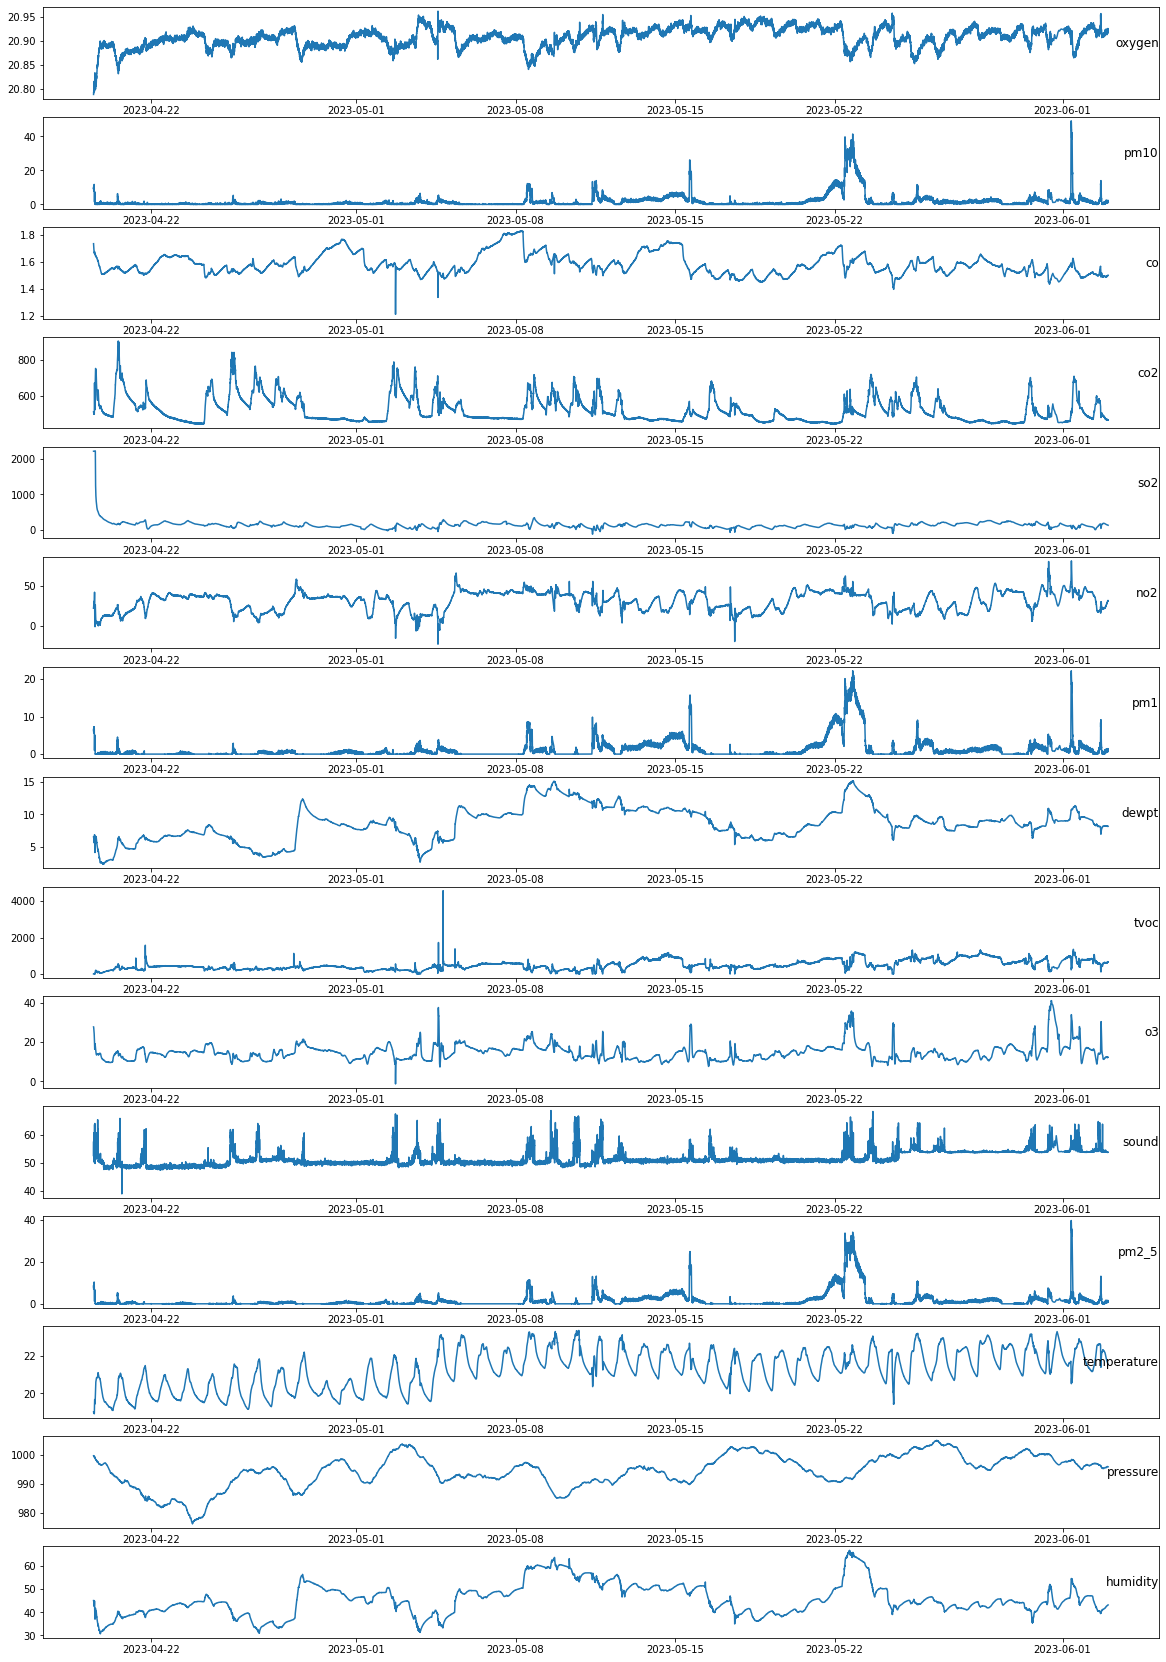

In [192]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

In [193]:
data

,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,o3,sound,pm2_5,temperature,pressure,humidity
date,,,,,,,,,,,,,,,
2023-04-19 11:39:01,20.789,9.315,1.735,507.934,2216.850,21.831,6.452,6.523,0.000,27.653,57.259,7.996,19.024,999.613,45.098
2023-04-19 11:41:03,20.790,9.040,1.730,504.029,2216.820,21.776,6.477,6.466,0.000,27.600,52.367,8.203,19.012,999.632,44.952
2023-04-19 11:43:05,20.789,10.338,1.726,503.302,2216.730,22.191,6.661,6.456,0.000,27.512,52.689,8.830,19.009,999.608,44.932
2023-04-19 11:45:06,20.793,9.173,1.723,503.272,2216.770,23.159,6.771,6.458,0.000,27.481,56.539,8.191,19.012,999.611,44.929
2023-04-19 11:47:08,20.792,8.218,1.720,503.708,2216.800,24.173,5.844,6.435,0.000,27.371,57.535,6.888,19.015,999.604,44.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-02 23:51:16,20.925,1.258,1.500,462.672,130.865,31.681,1.058,8.138,673.009,12.203,53.759,1.253,21.544,995.795,43.095
2023-06-02 23:53:17,20.925,1.608,1.500,460.642,130.676,31.438,0.786,8.145,659.945,12.199,53.738,0.881,21.537,995.800,43.136
2023-06-02 23:55:18,20.925,1.231,1.500,462.282,130.358,31.555,0.930,8.156,665.957,12.191,53.770,0.980,21.535,995.811,43.173


**Multivariate LSTM Predictive Modeling**

In [194]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [195]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [196]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,0.452520,0.206875
2,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,0.463491,0.222687
3,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,0.594671,0.206572
4,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,0.628608,0.173711
5,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,0.503492,0.206244


In [197]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-12].values, train.iloc[:, -12:].values
test_X, test_y = test.iloc[:, :-12].values, test.iloc[:, -12:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(28321, 1, 15) (28321, 12) (3146, 1, 15) (3146, 12)


Define the RNN model

Il y a 50 neurones dans la première couche cachée et 10 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 13 caractéristiques.

In [198]:
model = Sequential()
model.add(SimpleRNN(units = 50, activation='tanh', input_shape= (train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(units = 12))
model.compile(optimizer='adam', loss='mae')
print(model.summary())


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 50)                3300      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                612       
Total params: 3,912
Trainable params: 3,912
Non-trainable params: 0
_________________________________________________________________
None


Training the RNN model

Epoch 1/300
394/394 - 1s - loss: 0.1247 - val_loss: 0.0722
Epoch 2/300
394/394 - 0s - loss: 0.0672 - val_loss: 0.0431
Epoch 3/300
394/394 - 0s - loss: 0.0491 - val_loss: 0.0266
Epoch 4/300
394/394 - 0s - loss: 0.0400 - val_loss: 0.0237
Epoch 5/300
394/394 - 0s - loss: 0.0349 - val_loss: 0.0225
Epoch 6/300
394/394 - 0s - loss: 0.0316 - val_loss: 0.0239
Epoch 7/300
394/394 - 0s - loss: 0.0297 - val_loss: 0.0198
Epoch 8/300
394/394 - 0s - loss: 0.0284 - val_loss: 0.0188
Epoch 9/300
394/394 - 1s - loss: 0.0280 - val_loss: 0.0187
Epoch 10/300
394/394 - 1s - loss: 0.0280 - val_loss: 0.0192
Epoch 11/300
394/394 - 0s - loss: 0.0284 - val_loss: 0.0193
Epoch 12/300
394/394 - 1s - loss: 0.0285 - val_loss: 0.0187
Epoch 13/300
394/394 - 1s - loss: 0.0278 - val_loss: 0.0182
Epoch 14/300
394/394 - 1s - loss: 0.0275 - val_loss: 0.0190
Epoch 15/300
394/394 - 1s - loss: 0.0273 - val_loss: 0.0184
Epoch 16/300
394/394 - 1s - loss: 0.0270 - val_loss: 0.0183
Epoch 17/300
394/394 - 0s - loss: 0.0268 - val_lo

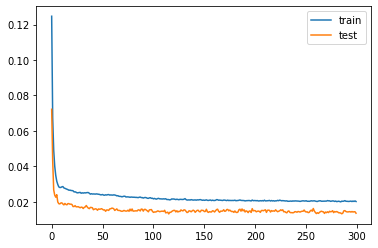

In [199]:
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating RNN models

In [200]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]
# selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]
inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
# oxygen_predict = inv_yhat[:, 0]
# pm10_predict = inv_yhat[:, 1]
# co_predict = inv_yhat[:, 2]
# co2_predict = inv_yhat[:, 3]
# so2_predict = inv_yhat[:, 4]
# no2_predict = inv_yhat[:, 5]
# pm1_predict = inv_yhat[:, 6]
# dewpt_predict = inv_yhat[:, 7]
# tvoc_predict = inv_yhat[:, 8]
# pm2_5_predict = inv_yhat[:, 9]

test_y = test_y.reshape((len(test_y), train_y.shape[1]))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.tail())
# oxygen_reel = inv_y[:, 0]
# pm10_reel = inv_y[:, 1]
# co_reel = inv_y[:, 2]
# co2_reel = inv_y[:, 3]
# so2_reel = inv_y[:, 4]
# no2_reel = inv_y[:, 5]
# pm1_reel = inv_y[:, 6]
# dewpt_reel = inv_y[:, 7]
# tvoc_reel = inv_y[:, 8]
# pm2_5_reel = inv_y[:, 9]

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

             0      1    2           3           4          5      6      7   \
3141  20.924999  1.258  1.5  462.671997  130.865005  31.681002  1.058  8.138   
3142  20.924999  1.608  1.5  460.641998  130.675995  31.438004  0.786  8.145   
3143  20.924999  1.231  1.5  462.282013  130.357986  31.555002  0.930  8.156   
3144  20.924000  1.321  1.5  460.177002  129.813004  31.540003  0.859  8.154   
3145  20.924000  1.341  1.5  460.992004  129.270020  31.233000  0.814  8.153   

              8          9          10     11  
3141  673.008972  12.203000  53.758999  1.253  
3142  659.944946  12.199000  53.737999  0.881  
3143  665.956970  12.190998  53.770000  0.980  
3144  661.143005  12.223999  53.804001  0.923  
3145  668.544983  12.214999  53.744999  1.050  


In [201]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


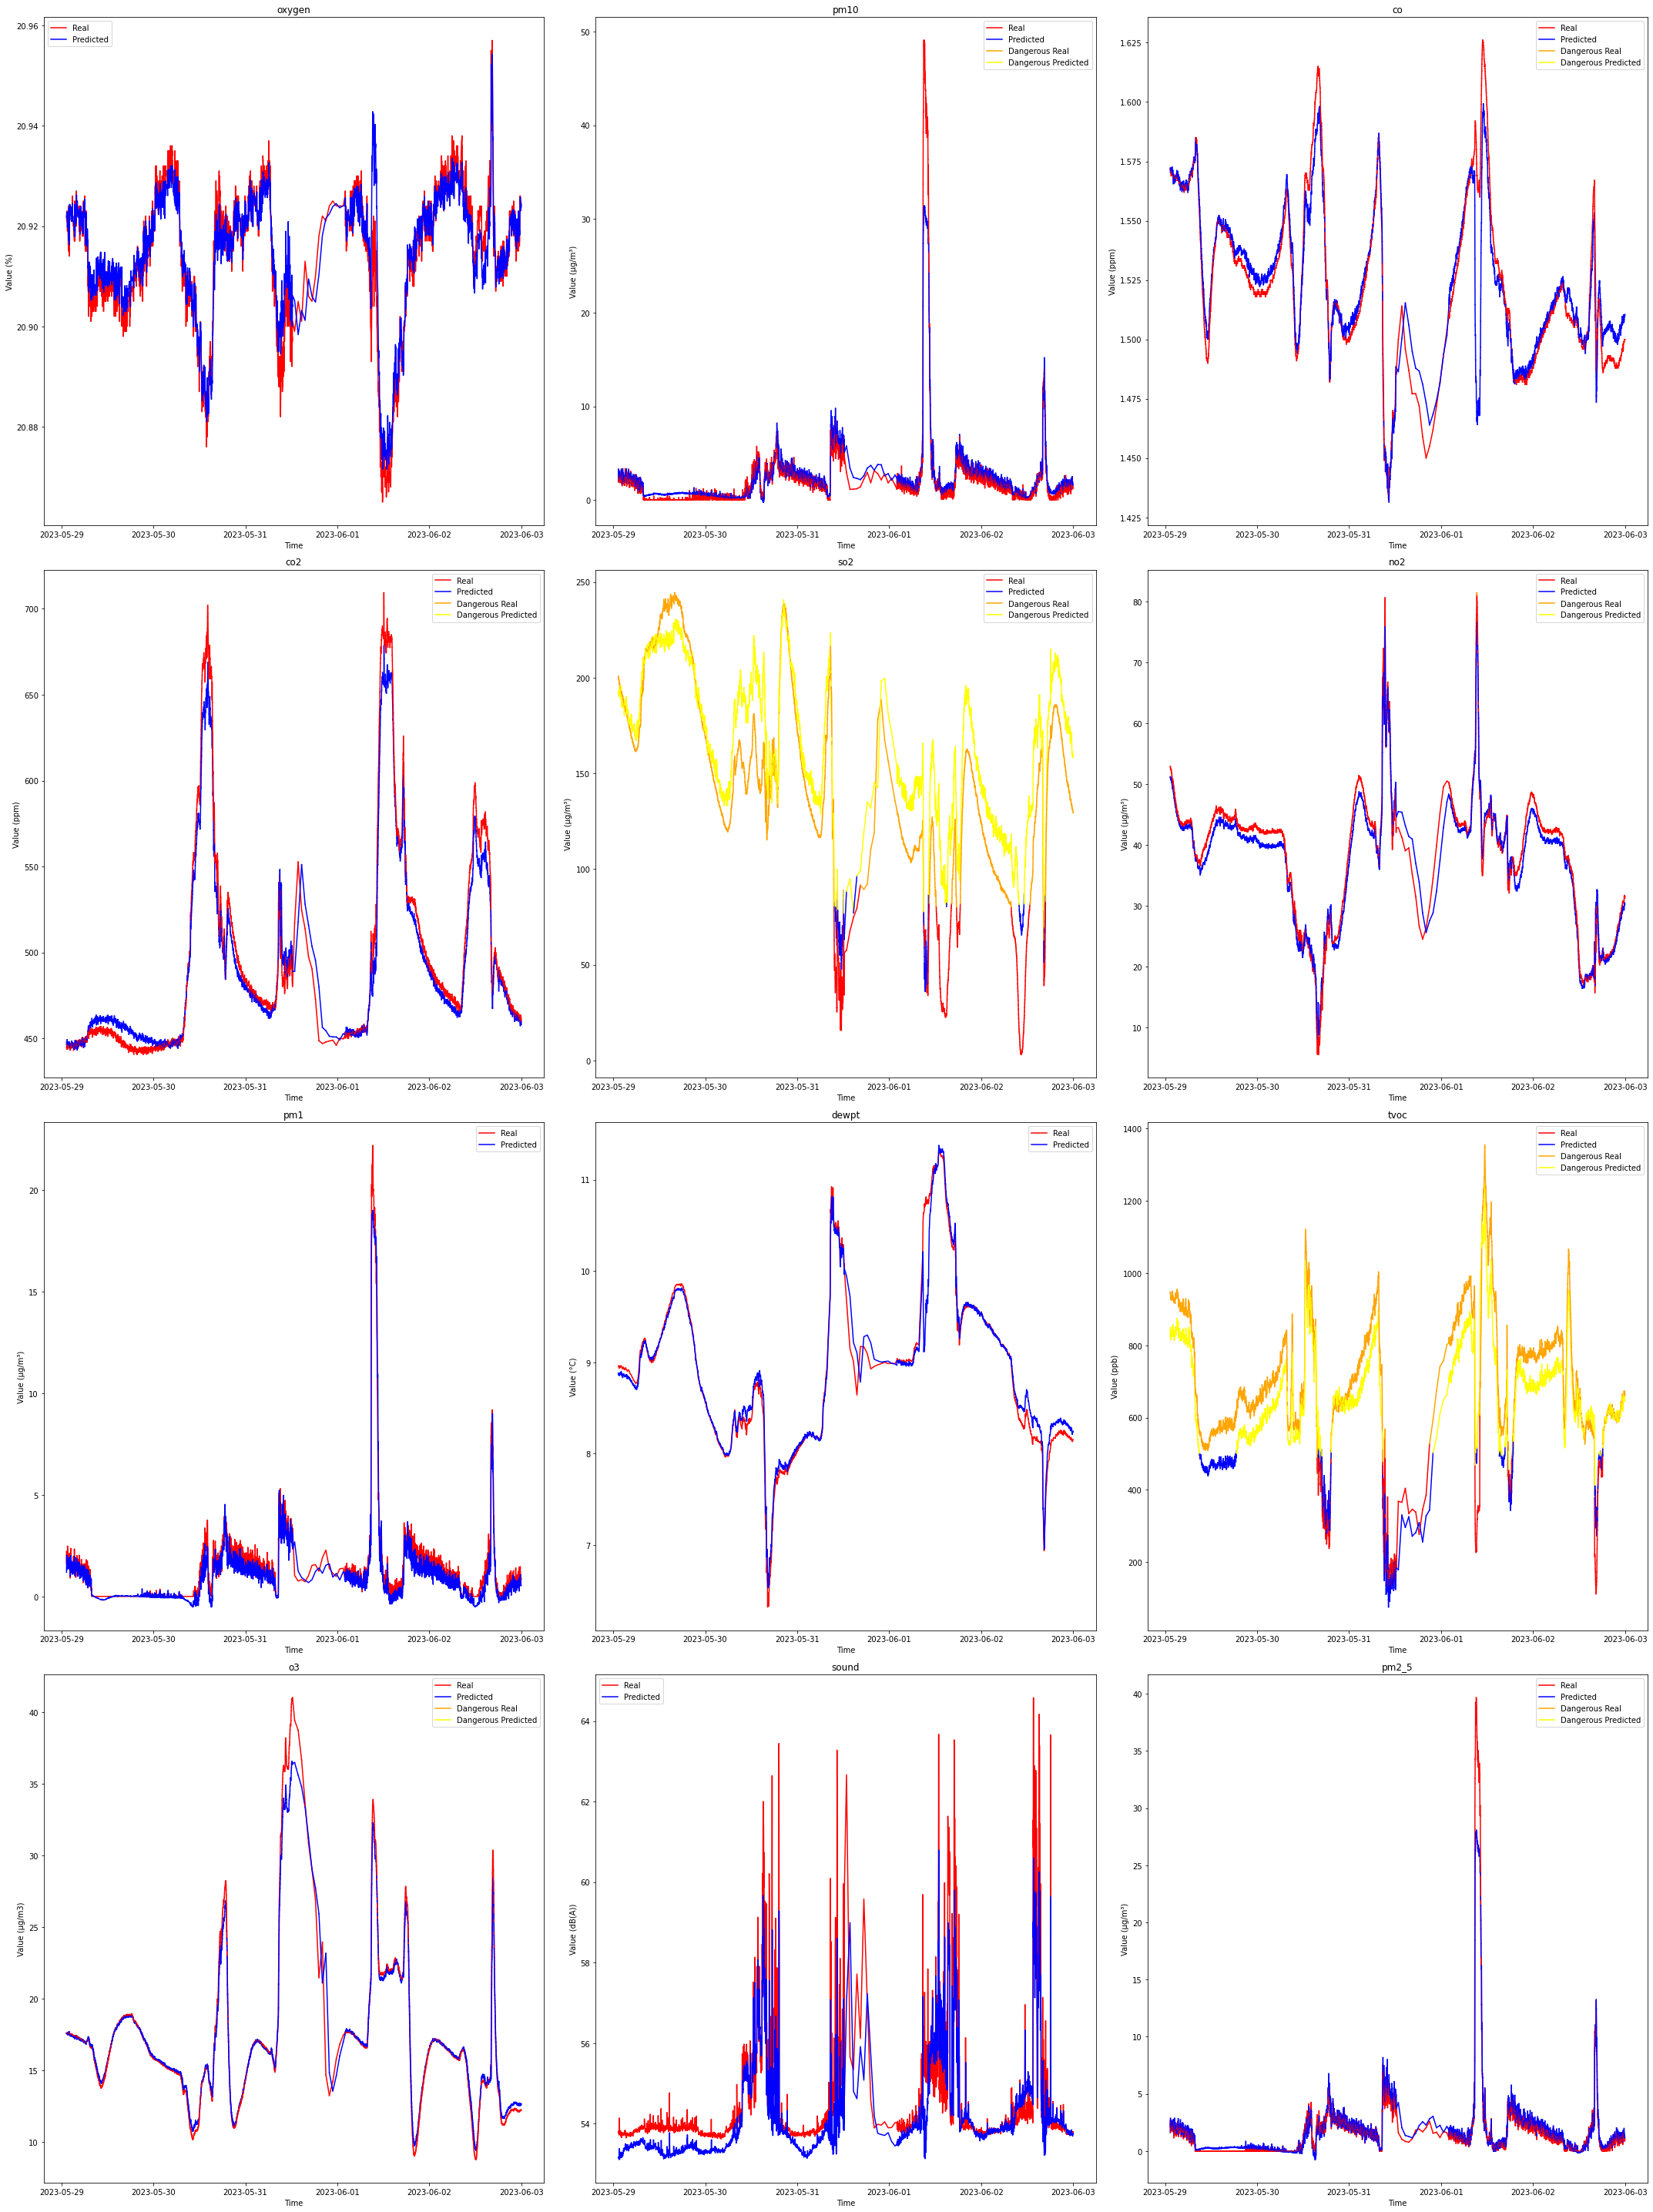

In [202]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [203]:
print(inv_y.shape, inv_yhat.shape)
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3' ,'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(3146, 12) (3146, 12)
Test RMSE for oxygen: 0.005
Test RMSE for pm10: 1.694
Test RMSE for co: 0.014
Test RMSE for co2: 10.645
Test RMSE for so2: 28.067
Test RMSE for no2: 1.786
Test RMSE for pm1: 0.544
Test RMSE for dewpt: 0.171
Test RMSE for tvoc: 84.064
Test RMSE for o3: 0.725
Test RMSE for sound: 0.923
Test RMSE for pm2_5: 1.148


In [204]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [205]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [206]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [207]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [208]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [209]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [210]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.921757  1.936482  1.572181  447.755310  191.083237  51.025974  1.184467   
1  20.922131  2.664596  1.571624  446.291534  192.555725  51.178036  1.638430   
2  20.922819  3.294730  1.570254  445.988739  193.121994  51.173561  2.033079   
3  20.921543  2.586312  1.572094  445.412354  193.012558  51.032646  1.588028   
4  20.922749  2.146551  1.570961  447.064117  189.944687  50.683971  1.314018   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.882279  822.935242  17.557217  ...  1.617171  2.695286  1.936482   
1  8.879315  842.525024  17.580627  ...  2.281989  3.803315  2.664596   
2  8.860039  848.536255  17.563038  ...  2.858321  4.763868  3.294730   
3  8.869841  839.902710  17.565104  ...  2.207612  3.679353  2.586312   
4  8.868409  815.576050  17.532753  ...  1.808832  3.014719  2.146551   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [211]:
from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.810553083280356


In [212]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

2550


anticiper

In [213]:
n_temps = 7
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [214]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
7,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.801613,0.128302,0.996262,0.474767,0.309373,0.309341,0.0,0.665280,0.644111,0.216786
8,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.795161,0.133763,0.996079,0.475073,0.326217,0.304760,0.0,0.660529,0.429998,0.235852
9,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.791935,0.125911,0.996032,0.475311,0.317209,0.303440,0.0,0.658497,0.629902,0.206345
10,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.787097,0.127217,0.995976,0.482153,0.320407,0.303828,0.0,0.655968,0.553239,0.226092
11,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.780645,0.128113,0.995951,0.490854,0.293249,0.299480,0.0,0.651643,0.479335,0.222612
12,0.052032,0.179446,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,...,0.775806,0.123357,0.995981,0.499776,0.322029,0.295908,0.0,0.646750,0.568265,0.221527
13,0.052032,0.165583,0.809677,0.129000,0.996343,0.468756,0.288925,0.314232,0.0,0.670976,...,0.772581,0.126193,0.996028,0.512571,0.305139,0.297461,0.0,0.641078,0.554329,0.208842
14,0.063583,0.197468,0.801613,0.128302,0.996262,0.474767,0.309373,0.309341,0.0,0.665280,...,0.767742,0.129162,0.996113,0.514346,0.310769,0.293190,0.0,0.636776,0.733109,0.224276
15,0.057808,0.198426,0.795161,0.133763,0.996079,0.475073,0.326217,0.304760,0.0,0.660529,...,0.766129,0.126945,0.996032,0.508239,0.324461,0.287833,0.0,0.631978,0.604245,0.237163
16,0.098267,0.184787,0.791935,0.125911,0.996032,0.475311,0.317209,0.303440,0.0,0.658497,...,0.761290,0.129026,0.996023,0.505100,0.258569,0.283252,0.0,0.627984,0.587720,0.177822


In [215]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows *0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 105) (28321, 12) (3140, 105) (3140, 12)


In [216]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(3140, 7, 15) (28321, 7, 15)


In [217]:
model = Sequential()
model.add(SimpleRNN(units = 50, activation='tanh', input_shape= (train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(units = 12))
model.compile(optimizer='adam', loss='mae')
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 50)                3300      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 12)                612       
Total params: 3,912
Trainable params: 3,912
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/300


394/394 - 1s - loss: 0.1170 - val_loss: 0.0519
Epoch 2/300
394/394 - 1s - loss: 0.0637 - val_loss: 0.0344
Epoch 3/300
394/394 - 1s - loss: 0.0486 - val_loss: 0.0307
Epoch 4/300
394/394 - 1s - loss: 0.0415 - val_loss: 0.0291
Epoch 5/300
394/394 - 1s - loss: 0.0367 - val_loss: 0.0272
Epoch 6/300
394/394 - 1s - loss: 0.0348 - val_loss: 0.0271
Epoch 7/300
394/394 - 1s - loss: 0.0318 - val_loss: 0.0245
Epoch 8/300
394/394 - 1s - loss: 0.0299 - val_loss: 0.0239
Epoch 9/300
394/394 - 1s - loss: 0.0308 - val_loss: 0.0246
Epoch 10/300
394/394 - 1s - loss: 0.0306 - val_loss: 0.0248
Epoch 11/300
394/394 - 1s - loss: 0.0307 - val_loss: 0.0261
Epoch 12/300
394/394 - 1s - loss: 0.0298 - val_loss: 0.0234
Epoch 13/300
394/394 - 1s - loss: 0.0298 - val_loss: 0.0227
Epoch 14/300
394/394 - 1s - loss: 0.0291 - val_loss: 0.0215
Epoch 15/300
394/394 - 1s - loss: 0.0284 - val_loss: 0.0209
Epoch 16/300
394/394 - 1s - loss: 0.0284 - val_loss: 0.0209
Epoch 17/300
394/394 - 1s - loss: 0.0278 - val_loss: 0.0220


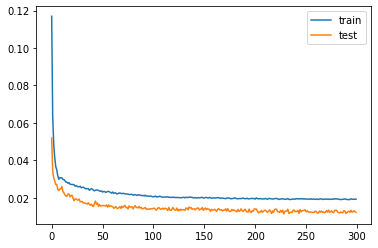

In [218]:
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [219]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns2]

test_y = test_y.reshape((len(test_y),  test_y.shape[1]))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, selected_columns2]

inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())
plt.show()


          0      1      2           3           4          5      6      7   \
0  20.919001  2.035  1.570  445.571014  197.987000  52.342999  1.433  8.938   
1  20.919001  1.995  1.569  444.832001  196.900986  52.308998  1.706  8.936   
2  20.919001  2.609  1.570  444.222992  196.459000  52.328003  2.481  8.949   
3  20.919001  2.462  1.570  443.811005  197.253998  52.031002  2.064  8.961   
4  20.920000  1.877  1.570  444.075989  196.863007  51.806999  1.677  8.963   

           8          9          10     11  
0  933.833984  17.576000  53.719002  1.876  
1  930.737000  17.565998  54.139000  1.980  
2  928.432983  17.568001  53.848000  2.607  
3  929.002991  17.548998  53.737000  2.462  
4  931.614014  17.556997  53.770000  1.787  


In [220]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


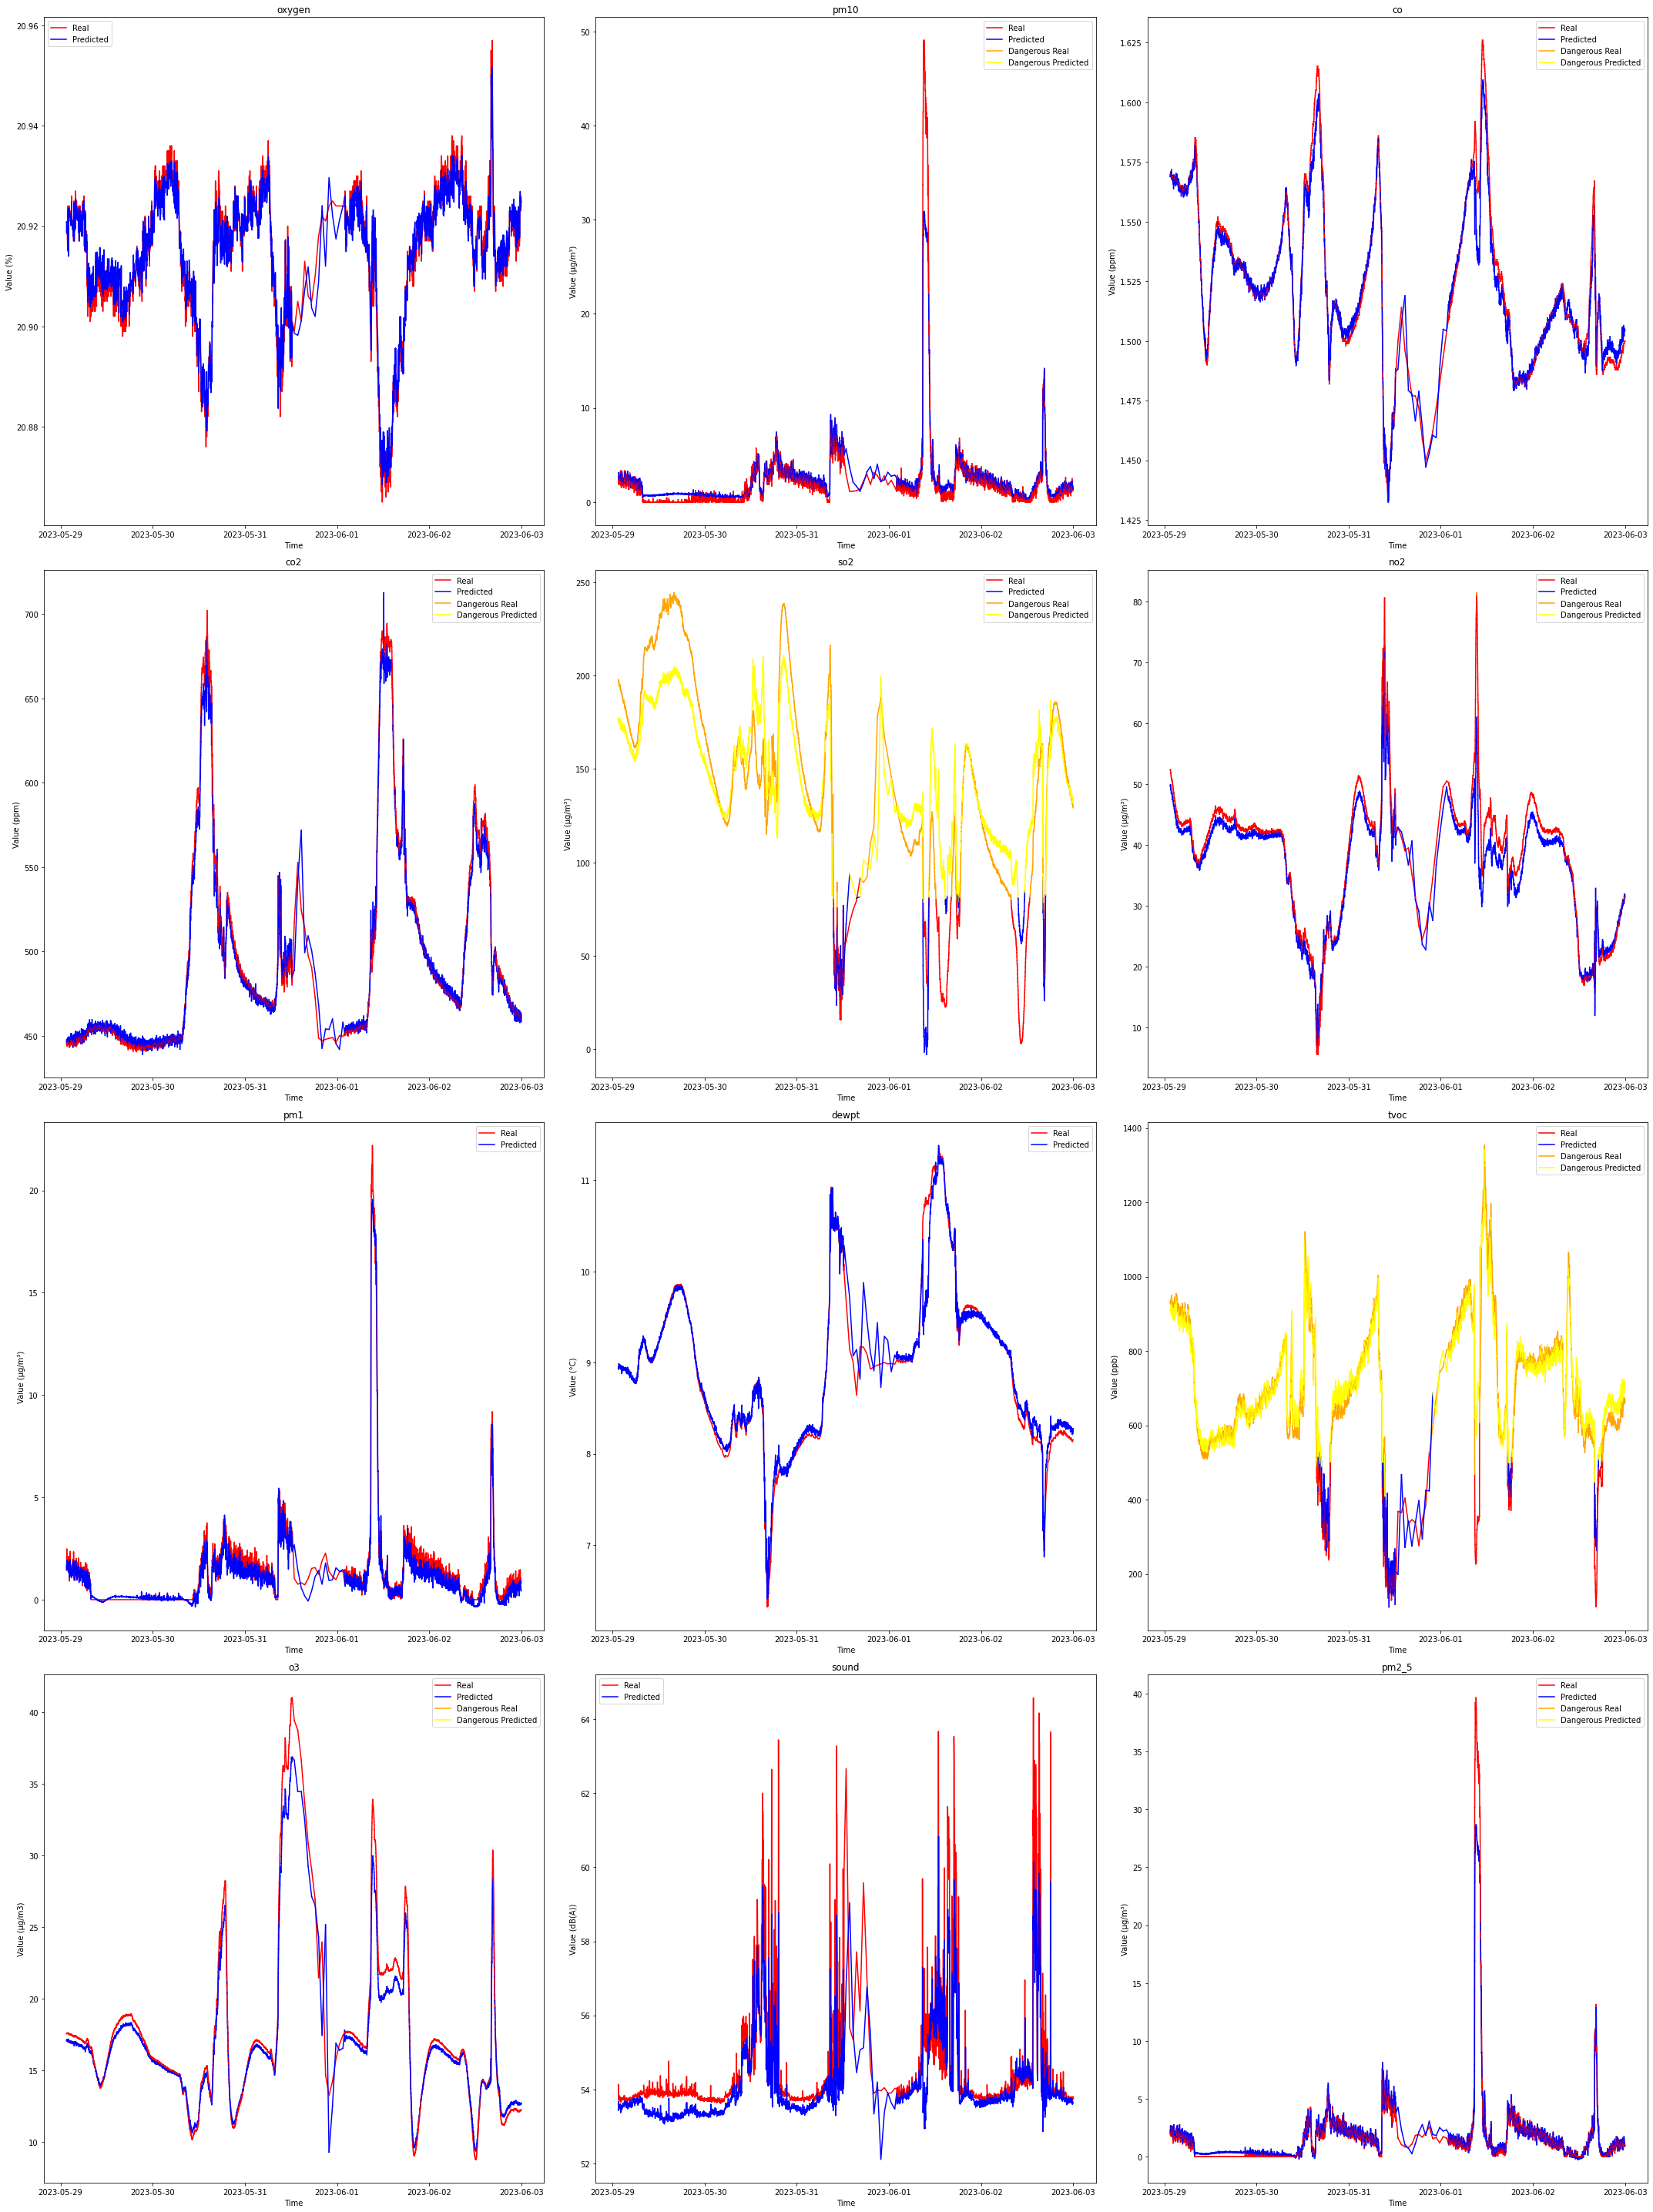

In [221]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [222]:
selected_columns2 = [i for i in range(inv_y.shape[1]) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]

In [223]:
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # mape = np.mean(np.abs((inv_y[:, i] - inv_yhat[:, i])/inv_y[:, i]))*100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

Test RMSE for oxygen: 0.003
Test RMSE for pm10: 1.801
Test RMSE for co: 0.006
Test RMSE for co2: 6.579
Test RMSE for so2: 24.901
Test RMSE for no2: 3.038
Test RMSE for pm1: 0.509
Test RMSE for dewpt: 0.161
Test RMSE for tvoc: 56.069
Test RMSE for o3: 1.013
Test RMSE for sound: 0.945
Test RMSE for pm2_5: 1.135


In [224]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [225]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [226]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [227]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [228]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [229]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [230]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.920879  2.711834  1.568935  446.327576  177.262344  49.631523  1.641534   
1  20.918659  2.455379  1.568874  447.605927  175.768250  49.811001  1.455748   
2  20.918514  2.523722  1.569094  446.397339  176.067093  49.878899  1.492419   
3  20.918888  3.104651  1.570755  446.303009  175.922348  49.669724  1.920273   
4  20.919096  3.125398  1.569306  445.831268  175.349640  49.036415  1.905881   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.926029  913.337830  17.137115  ...  2.287945  3.813242  2.711834   
1  8.955557  910.907959  17.059589  ...  2.034113  3.390189  2.455379   
2  8.942114  907.911743  17.070017  ...  2.082124  3.470207  2.523722   
3  8.955748  906.954895  17.093521  ...  2.665563  4.442604  3.104651   
4  8.990841  909.832886  17.081547  ...  2.680781  4.467968  3.125398   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [231]:
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.795859872611465


In [232]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

2499
